In [56]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image

from google.colab import runtime


In [57]:
transforms = {
    'train':
    transforms.Compose( # composing several transforms together
    [transforms.ToTensor(), # to tensor object
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # mean = 0.5, std = 0.5
     transforms.Resize((256,256)) # Resize to min image size
     ]),

    'val':
    transforms.Compose( # composing several transforms together
    [transforms.ToTensor(), # to tensor object
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # mean = 0.5, std = 0.5
     transforms.Resize((256,256)) # Resize to min image size
     ]),

    'test':
    transforms.Compose( # composing several transforms together
    [transforms.ToTensor(), # to tensor object
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # mean = 0.5, std = 0.5
     transforms.Resize((256,256)) # Resize to min image size
     ])
}

batch_size = 4

In [58]:
train_data = datasets.Flowers102(root='./data', split='train', transform=transforms['train'], download=True)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

In [59]:
val_data = datasets.Flowers102(root='./data', split='val', transform=transforms['val'], download=False)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [60]:
test_data = datasets.Flowers102(root='./data', split='test', transform=transforms['test'], download=False)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

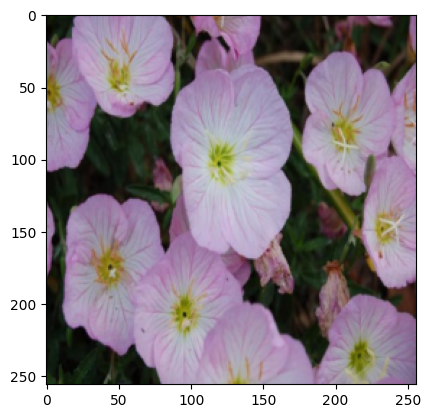

In [61]:
minX = 1000
minY = 1000

def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

#Find min X and Y (500,500)
#dataiter = iter(train_data)
#i = 0
#while i < 1020:
#  im, lbl = next(dataiter)
#  minY = min(minY, im.size(dim=1))
#  minX = min(minX, im.size(dim=2))
#  i+=1

#print(minX)
#print(minY)

dataiter = iter(train_data)
images, lbls = next(dataiter)
imshow(torchvision.utils.make_grid(images))
# call function on our images


In [62]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [63]:
class BasicNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*25*25, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 102)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [64]:
#Architecture inspired by https://poloclub.github.io/cnn-explainer/#article-input
#and PyTorch for Deep Learning & Machine Learning – Full Course by freeCodeCamp.org https://www.youtube.com/watch?v=V_xro1bcAuA
class CNNv1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    #Block is comprised of multiple layers
    self.conv_block_1 = nn.Sequential(
        #Conv layer to extract features
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3, #Size of the kernel it looks at
                  stride=1, #How far it steps between kernels
                  padding=1), #Added to the edges to stop the miage decreasing in size
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
         nn.ReLU(),
         nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*64*64,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x

In [65]:
model = CNNv1(input_shape=3,
              hidden_units=102,
              output_shape=102).to(device)
print(model)

CNNv1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=417792, out_features=102, bias=True)
  )
)


In [66]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [67]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [68]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 9
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)
test(test_dataloader, model, loss_fn)

print("Done!")
runtime.unassign()

Epoch 1
-------------------------------
loss: 4.620847  [    4/ 1020]
loss: 4.648822  [  404/ 1020]
loss: 4.604095  [  804/ 1020]
Test Error: 
 Accuracy: 3.1%, Avg loss: 4.519764 

Epoch 2
-------------------------------
loss: 4.470914  [    4/ 1020]
loss: 4.221200  [  404/ 1020]
loss: 4.127958  [  804/ 1020]
Test Error: 
 Accuracy: 9.2%, Avg loss: 3.958663 

Epoch 3
-------------------------------
loss: 2.856895  [    4/ 1020]
loss: 3.638069  [  404/ 1020]
loss: 2.634839  [  804/ 1020]
Test Error: 
 Accuracy: 10.6%, Avg loss: 3.984053 

Epoch 4
-------------------------------
loss: 1.303822  [    4/ 1020]
loss: 3.274050  [  404/ 1020]
loss: 2.277694  [  804/ 1020]
Test Error: 
 Accuracy: 12.6%, Avg loss: 4.012693 

Epoch 5
-------------------------------
loss: 0.659686  [    4/ 1020]
loss: 0.055146  [  404/ 1020]
loss: 2.887039  [  804/ 1020]
Test Error: 
 Accuracy: 14.6%, Avg loss: 4.828225 

Epoch 6
-------------------------------
loss: 0.007356  [    4/ 1020]
loss: 0.105699  [  404